Saving datos_ventas_inf.csv to datos_ventas_inf.csv
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.1316 - val_loss: 0.2680
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1331 - val_loss: 0.2464
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1182 - val_loss: 0.2245
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0836 - val_loss: 0.2027
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0829 - val_loss: 0.1800
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0725 - val_loss: 0.1549
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0619 - val_loss: 0.1280
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0449 - val_loss: 0.1012
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0359 - val_loss: 0.0766
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0244 - val_loss: 0.0567
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0181 - val_loss: 0.0428
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0190 - val_loss: 0.0346
E

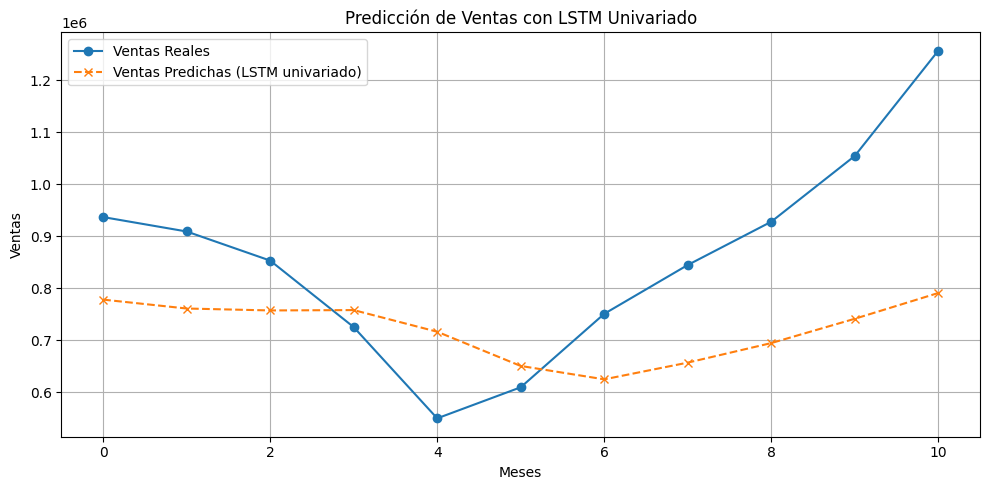

In [1]:
# Paso 1: Instalación y carga de librerías
!pip install -q tensorflow scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from google.colab import files

# Paso 2: Subir archivo CSV
uploaded = files.upload()

# Paso 3: Leer y preparar datos
df = pd.read_csv("datos_ventas_inf.csv")
df["fecha"] = pd.to_datetime(df["fecha"], format="%Y-%m")
df = df.sort_values("fecha")
ventas = df["venta"].values.reshape(-1, 1)

# Paso 4: Escalar ventas
scaler = MinMaxScaler()
ventas_scaled = scaler.fit_transform(ventas)

# Paso 5: Crear secuencias de entrada
def crear_secuencias(data, ventana=3):
    X, y = [], []
    for i in range(ventana, len(data)):
        X.append(data[i-ventana:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

ventana = 3
X, y = crear_secuencias(ventas_scaled, ventana)

# Paso 6: Reshape para LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Paso 7: Dividir en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Paso 8: Definir y entrenar modelo
modelo_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
modelo_lstm.compile(optimizer='adam', loss='mse')
modelo_lstm.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=1)

# Paso 9: Predicciones y desescalado
y_pred_scaled = modelo_lstm.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# Paso 10: Calcular métricas
y_pred = y_pred.flatten()
y_real = y_real.flatten()
non_zero = y_real != 0

mae = mean_absolute_error(y_real, y_pred)
mape = np.mean(np.abs((y_real[non_zero] - y_pred[non_zero]) / y_real[non_zero])) * 100
bias = np.mean(y_pred - y_real)
bias_pct = (bias / np.mean(y_real)) * 100

print(f"🔹 MAE (LSTM univariado, escala real): {mae:,.2f} unidades")
print(f"🔸 MAPE: {mape:.2f}%")
print(f"🔸 BIAS: {bias_pct:.2f}%")

# Paso 11: Visualización
plt.figure(figsize=(10,5))
plt.plot(y_real, label="Ventas Reales", marker="o")
plt.plot(y_pred, label="Ventas Predichas (LSTM univariado)", marker="x", linestyle="--")
plt.title("Predicción de Ventas con LSTM Univariado")
plt.xlabel("Meses")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
